# Домашнее задание 1

## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
        
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
- hit  — взять ещё одну карту;
- stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

# 1

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [149]:
import gym
env = gym.make('Blackjack-v1', natural=True)
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import random

In [139]:
%%time
num_episodes = 500000
avg_reward = 0

def simple_policy(state):
    return 0 if state[0] >= 19 else 1

for i in range(num_episodes):
    state = env.reset()
    is_done = False
    while not is_done:
        action = simple_policy(state)
        state, reward, is_done, _ = env.step(action)
    avg_reward += (reward - avg_reward) / (i + 1)
    
print(f"Выигрыш от наивной стратегии: {avg_reward}")

Выигрыш от наивной стратегии: -0.19856399999999746
Wall time: 22.1 s


# 2

Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

#### Monte Carlo

In [151]:
def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def MC_inference(Q, num_episodes=100000, env=env):
    avg_reward = 0
    for i in range(num_episodes):
        state = env.reset()
        is_done = False
        while not is_done:
            action = np.argmax(Q[state])
            state, reward, is_done, _ = env.step(action)
        avg_reward += (reward - avg_reward) / (i + 1)
    return avg_reward


def evaluate_policy(Q, episodes=10000, env=env):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += 1
    return wins / episodes

def monte_carlo(gamma=1., episodes=5000, env=env, evaluate=False):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)
    
    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], env.action_space.n)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
            state = new_state
        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
    return Q, evaluations

In [152]:
%%time
num_episodes = 100000
Q_mc, evaluations = monte_carlo(episodes=500000)
sum_of_rewards = MC_inference(Q_mc, num_episodes=num_episodes)

print(f"Средний выигрыш после {num_episodes} эпизодов Monte Carlo: {sum_of_rewards}")

Средний выигрыш после 100000 эпизодов Monte Carlo: -0.055779999999999635
Wall time: 48.1 s


# 3

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

#### Grid search - подбор gamma

In [140]:
%%time
best_sum_of_rewards = -0.19 # наивная стратегия
best_gamma = 0

for gamma in tqdm(np.linspace(0., 1, 100)):
    Q_mc, evaluations = monte_carlo(gamma=1., episodes=500000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    if sum_of_rewards > best_sum_of_rewards:
        best_sum_of_rewards = sum_of_rewards
        best_gamma = gamma

print(f"Лучший выигрыш: {best_sum_of_rewards}, best_gamma: {best_gamma}")

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:25:20<00:00, 51.21s/it]

Лучший выигрыш: -0.03971999999999939, best_gamma: 0.16161616161616163
Wall time: 1h 25min 20s


In [141]:
%%time
sums_of_rewards = []
best_sum_of_rewards = [-0.19] # наивная стратегия

for i in tqdm(range(100)):
    Q_mc, evaluations = monte_carlo(gamma=0.16, episodes=i*1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    sums_of_rewards.append(sum_of_rewards)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:31<00:00,  9.32s/it]

Wall time: 15min 31s


Построим график среднего дохода по ходу обучения.

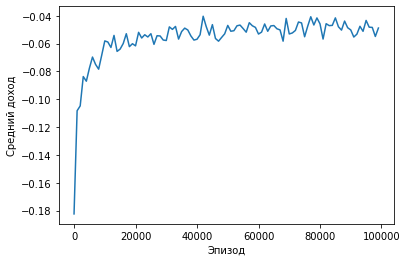

In [142]:
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Средний доход')
plt.show()

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:


* double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


# 4

Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [143]:
class Doubled_Blackjack_Env:
    def __init__(self):
        self.base_env = gym.make('Blackjack-v1')
        self.action_space = list(range(3))
        
    def reset(self):
        return self.base_env.reset()
    
    def step(self, action):
        if action == 2:
            
            state, reward, is_done, _ = self.base_env.step(1)
            
            if is_done:
                return state, 2*reward, is_done, _
            
            else:
                
                state, reward, is_done, _ = self.base_env.step(0)
                return state, 2*reward, is_done, _
            
        else:
            return self.base_env.step(action)

In [144]:
env = Doubled_Blackjack_Env()

In [145]:
Q_mc, evaluations = monte_carlo(episodes=500000)
MC_inference(Q_mc, num_episodes=100000)

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06765000000000193


-0.06765000000000193

#### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [146]:
%%time
best_sum_of_rewards = -0.19 # наивная стратегия
best_gamma = 0

for gamma in tqdm(np.linspace(0., 1, 100)):
    Q_mc, evaluations = monte_carlo(gamma=1., episodes=500000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    if sum_of_rewards > best_sum_of_rewards:
        best_sum_of_rewards = sum_of_rewards
        best_gamma = gamma

print(f"Лучший выигрыш: {best_sum_of_rewards}, best_gamma: {best_gamma}")

  1%|▊                                                                               | 1/100 [00:47<1:18:50, 47.78s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06044000000000038


  2%|█▌                                                                              | 2/100 [01:35<1:17:53, 47.69s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05247000000000036


  3%|██▍                                                                             | 3/100 [02:18<1:13:33, 45.51s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05211000000000007


  4%|███▏                                                                            | 4/100 [03:00<1:10:42, 44.19s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05406999999999957


  5%|████                                                                            | 5/100 [03:43<1:09:29, 43.89s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05222999999999996


  6%|████▊                                                                           | 6/100 [04:26<1:08:10, 43.51s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05799999999999964


  7%|█████▌                                                                          | 7/100 [05:08<1:06:47, 43.09s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05935999999999956


  8%|██████▍                                                                         | 8/100 [05:52<1:06:32, 43.39s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.04999999999999989


  9%|███████▏                                                                        | 9/100 [06:37<1:06:16, 43.69s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.04924999999999954


 10%|███████▉                                                                       | 10/100 [07:21<1:05:52, 43.92s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.059690000000000215


 11%|████████▋                                                                      | 11/100 [08:04<1:04:36, 43.55s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05641000000000029


 12%|█████████▍                                                                     | 12/100 [08:48<1:04:08, 43.74s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.057479999999999684


 13%|██████████▎                                                                    | 13/100 [09:31<1:03:17, 43.65s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06222000000000002


 14%|███████████                                                                    | 14/100 [10:15<1:02:22, 43.52s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06039000000000038


 15%|███████████▊                                                                   | 15/100 [10:57<1:01:14, 43.23s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05472000000000006


 16%|████████████▋                                                                  | 16/100 [11:40<1:00:18, 43.08s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05058999999999984


 17%|█████████████▊                                                                   | 17/100 [12:23<59:43, 43.18s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.047729999999999925


 18%|██████████████▌                                                                  | 18/100 [13:06<58:38, 42.91s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06331000000000091


 19%|███████████████▍                                                                 | 19/100 [13:48<57:35, 42.66s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06421999999999996


 20%|████████████████▏                                                                | 20/100 [14:30<56:49, 42.62s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.057280000000000414


 21%|█████████████████                                                                | 21/100 [15:12<55:52, 42.43s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06260999999999993


 22%|█████████████████▊                                                               | 22/100 [15:55<55:07, 42.40s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.059509999999999896


 23%|██████████████████▋                                                              | 23/100 [16:39<55:00, 42.86s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.048200000000000576


 24%|███████████████████▍                                                             | 24/100 [17:21<54:14, 42.83s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05399999999999943


 25%|████████████████████▎                                                            | 25/100 [18:04<53:28, 42.77s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.056460000000000274


 26%|█████████████████████                                                            | 26/100 [18:48<53:10, 43.12s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05149999999999954


 27%|█████████████████████▊                                                           | 27/100 [19:30<52:09, 42.87s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05564999999999976


 28%|██████████████████████▋                                                          | 28/100 [20:14<51:37, 43.02s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05715999999999996


 29%|███████████████████████▍                                                         | 29/100 [20:56<50:52, 43.00s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.059700000000000274


 30%|████████████████████████▎                                                        | 30/100 [21:39<50:04, 42.92s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.051799999999999444


 31%|█████████████████████████                                                        | 31/100 [22:23<49:30, 43.05s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.052219999999999545


 32%|█████████████████████████▉                                                       | 32/100 [23:05<48:41, 42.96s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05320000000000005


 33%|██████████████████████████▋                                                      | 33/100 [23:48<47:57, 42.94s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05466000000000034


 34%|███████████████████████████▌                                                     | 34/100 [24:31<47:13, 42.92s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06592000000000083


 35%|████████████████████████████▎                                                    | 35/100 [25:15<46:44, 43.15s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.04919999999999953


 36%|█████████████████████████████▏                                                   | 36/100 [25:58<46:07, 43.24s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.051930000000000476


 37%|█████████████████████████████▉                                                   | 37/100 [26:42<45:27, 43.29s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0657700000000004


 38%|██████████████████████████████▊                                                  | 38/100 [27:25<44:39, 43.21s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.04934999999999994


 39%|███████████████████████████████▌                                                 | 39/100 [28:07<43:45, 43.04s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.054210000000000036


 40%|████████████████████████████████▍                                                | 40/100 [28:50<42:50, 42.85s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06735999999999984


 41%|█████████████████████████████████▏                                               | 41/100 [29:33<42:09, 42.87s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05020999999999981


 42%|██████████████████████████████████                                               | 42/100 [30:16<41:38, 43.08s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06207999999999961


 43%|██████████████████████████████████▊                                              | 43/100 [31:00<41:01, 43.19s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.04437000000000016


 44%|███████████████████████████████████▋                                             | 44/100 [31:43<40:14, 43.12s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.062480000000000264


 45%|████████████████████████████████████▍                                            | 45/100 [32:24<39:10, 42.74s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06417999999999911


 46%|█████████████████████████████████████▎                                           | 46/100 [33:08<38:43, 43.04s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.045179999999999894


 47%|██████████████████████████████████████                                           | 47/100 [33:51<37:56, 42.94s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06010000000000086


 48%|██████████████████████████████████████▉                                          | 48/100 [34:35<37:28, 43.25s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.059679999999999865


 49%|███████████████████████████████████████▋                                         | 49/100 [35:17<36:24, 42.83s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06636999999999962


 50%|████████████████████████████████████████▌                                        | 50/100 [36:01<35:56, 43.14s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06265000000000097


 51%|█████████████████████████████████████████▎                                       | 51/100 [36:44<35:13, 43.13s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.053420000000000634


 52%|██████████████████████████████████████████                                       | 52/100 [37:26<34:24, 43.02s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05793000000000001


 53%|██████████████████████████████████████████▉                                      | 53/100 [38:09<33:38, 42.94s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06448999999999983


 54%|███████████████████████████████████████████▋                                     | 54/100 [38:53<33:01, 43.07s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.049210000000000205


 55%|████████████████████████████████████████████▌                                    | 55/100 [39:36<32:24, 43.21s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.04876999999999973


 56%|█████████████████████████████████████████████▎                                   | 56/100 [40:19<31:37, 43.12s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.056020000000000306


 57%|██████████████████████████████████████████████▏                                  | 57/100 [41:02<30:52, 43.08s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0596800000000006


 58%|██████████████████████████████████████████████▉                                  | 58/100 [41:46<30:20, 43.34s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06051999999999996


 59%|███████████████████████████████████████████████▊                                 | 59/100 [42:29<29:31, 43.22s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05958000000000088


 60%|████████████████████████████████████████████████▌                                | 60/100 [43:12<28:49, 43.24s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.04270999999999929


 61%|█████████████████████████████████████████████████▍                               | 61/100 [43:59<28:45, 44.25s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05835999999999973


 62%|██████████████████████████████████████████████████▏                              | 62/100 [44:50<29:15, 46.19s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06177999999999892


 63%|███████████████████████████████████████████████████                              | 63/100 [45:39<29:10, 47.31s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.052919999999999814


 64%|███████████████████████████████████████████████████▊                             | 64/100 [46:32<29:23, 48.99s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.04962000000000025


 65%|████████████████████████████████████████████████████▋                            | 65/100 [47:21<28:25, 48.74s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.044520000000000254


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [48:11<27:54, 49.25s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05156999999999982


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [48:57<26:31, 48.23s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.055040000000000616


 68%|███████████████████████████████████████████████████████                          | 68/100 [49:44<25:32, 47.88s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.054639999999999966


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [50:30<24:28, 47.38s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.050220000000000015


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [51:19<23:54, 47.83s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06418000000000024


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [52:07<23:06, 47.80s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05382999999999985


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [52:51<21:50, 46.79s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05512999999999993


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [53:39<21:08, 46.97s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06377000000000049


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [54:24<20:10, 46.56s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0611800000000001


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [55:11<19:22, 46.51s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05232000000000006


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [55:57<18:36, 46.52s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0562999999999996


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [56:42<17:40, 46.10s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05158999999999977


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [57:29<17:00, 46.39s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.04078000000000013


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [58:15<16:09, 46.15s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06447000000000098


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [58:59<15:09, 45.50s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05401999999999987


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [59:44<14:20, 45.27s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06253000000000022


 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:00:27<13:26, 44.80s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05729999999999948


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:01:12<12:40, 44.74s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05620999999999967


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:02:06<12:40, 47.55s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.053239999999999905


 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:02:56<12:04, 48.27s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05239999999999947


 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:03:45<11:17, 48.40s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05474999999999965


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:04:32<10:24, 48.07s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05098999999999978


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:05:17<09:26, 47.23s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05340999999999909


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:06:04<08:39, 47.20s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06233999999999988


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:06:52<07:53, 47.35s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.04380999999999974


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:07:40<07:08, 47.65s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06332000000000029


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:08:28<06:21, 47.69s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06085999999999962


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:09:20<05:42, 48.94s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0620599999999996


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:10:08<04:52, 48.78s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.061070000000000686


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:11:07<04:18, 51.64s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05043000000000016


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:12:04<03:33, 53.25s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.060800000000000805


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:12:51<02:34, 51.50s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05512999999999921


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:13:34<01:38, 49.02s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05308999999999964


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:14:19<00:47, 47.84s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05488999999999996


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:15:08<00:00, 45.08s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.060270000000000004
Лучший выигрыш: -0.04078000000000013, best_gamma: 0.7777777777777778
Wall time: 1h 15min 8s


In [147]:
%%time
sums_of_rewards = []
best_sum_of_rewards = [-0.197] # наивная стратегия

for i in tqdm(range(100)):
    Q_mc, evaluations = monte_carlo(gamma=0.77, episodes=i*1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    sums_of_rewards.append(sum_of_rewards)

  1%|▊                                                                                 | 1/100 [00:03<06:03,  3.67s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.18149999999999883


  2%|█▋                                                                                | 2/100 [00:07<06:27,  3.96s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.18246000000000107


  3%|██▍                                                                               | 3/100 [00:12<06:41,  4.14s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.19783999999999888


  4%|███▎                                                                              | 4/100 [00:16<06:47,  4.25s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.15462999999999805


  5%|████                                                                              | 5/100 [00:22<07:36,  4.80s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.14558999999999603


  6%|████▉                                                                             | 6/100 [00:29<08:55,  5.70s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.1317399999999986


  7%|█████▋                                                                            | 7/100 [00:36<09:23,  6.06s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.13761000000000115


  8%|██████▌                                                                           | 8/100 [00:41<08:34,  5.59s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.1135599999999996


  9%|███████▍                                                                          | 9/100 [00:46<08:06,  5.34s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.10824999999999967


 10%|████████                                                                         | 10/100 [00:51<08:15,  5.50s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.11149000000000066


 11%|████████▉                                                                        | 11/100 [00:57<08:22,  5.65s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.11518000000000043


 12%|█████████▋                                                                       | 12/100 [01:03<08:19,  5.67s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.09006000000000033


 13%|██████████▌                                                                      | 13/100 [01:10<08:33,  5.91s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.10865999999999977


 14%|███████████▎                                                                     | 14/100 [01:15<08:25,  5.87s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0944800000000006


 15%|████████████▏                                                                    | 15/100 [01:22<08:37,  6.09s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.1010799999999997


 16%|████████████▉                                                                    | 16/100 [01:29<09:00,  6.43s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.09747000000000026


 17%|█████████████▊                                                                   | 17/100 [01:37<09:40,  6.99s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.09522999999999979


 18%|██████████████▌                                                                  | 18/100 [01:44<09:18,  6.81s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.09645000000000094


 19%|███████████████▍                                                                 | 19/100 [01:51<09:21,  6.93s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0884699999999988


 20%|████████████████▏                                                                | 20/100 [01:58<09:16,  6.95s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.09612000000000037


 21%|█████████████████                                                                | 21/100 [02:05<09:09,  6.96s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.09340000000000051


 22%|█████████████████▊                                                               | 22/100 [02:12<09:08,  7.03s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07406000000000038


 23%|██████████████████▋                                                              | 23/100 [02:19<09:05,  7.09s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.08446999999999875


 24%|███████████████████▍                                                             | 24/100 [02:27<09:17,  7.34s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0935199999999993


 25%|████████████████████▎                                                            | 25/100 [02:34<08:51,  7.09s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.09050999999999994


 26%|█████████████████████                                                            | 26/100 [02:42<09:07,  7.39s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0789700000000001


 27%|█████████████████████▊                                                           | 27/100 [02:51<09:32,  7.84s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.08120000000000044


 28%|██████████████████████▋                                                          | 28/100 [02:59<09:22,  7.81s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.08030000000000065


 29%|███████████████████████▍                                                         | 29/100 [03:07<09:31,  8.05s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07859000000000019


 30%|████████████████████████▎                                                        | 30/100 [03:18<10:17,  8.82s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07781000000000059


 31%|█████████████████████████                                                        | 31/100 [03:31<11:37, 10.10s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0729600000000001


 32%|█████████████████████████▉                                                       | 32/100 [03:39<10:36,  9.37s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0804499999999991


 33%|██████████████████████████▋                                                      | 33/100 [03:46<09:47,  8.77s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07974000000000009


 34%|███████████████████████████▌                                                     | 34/100 [03:53<09:11,  8.36s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07900999999999951


 35%|████████████████████████████▎                                                    | 35/100 [04:01<08:54,  8.22s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07519000000000021


 36%|█████████████████████████████▏                                                   | 36/100 [04:10<08:49,  8.27s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0879600000000007


 37%|█████████████████████████████▉                                                   | 37/100 [04:18<08:52,  8.46s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06693999999999886


 38%|██████████████████████████████▊                                                  | 38/100 [04:29<09:13,  8.94s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07022000000000041


 39%|███████████████████████████████▌                                                 | 39/100 [04:37<08:59,  8.85s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07905999999999928


 40%|████████████████████████████████▍                                                | 40/100 [04:50<10:01, 10.03s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06808000000000071


 41%|█████████████████████████████████▏                                               | 41/100 [04:59<09:35,  9.76s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0780000000000007


 42%|██████████████████████████████████                                               | 42/100 [05:10<09:38,  9.98s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06831000000000013


 43%|██████████████████████████████████▊                                              | 43/100 [05:19<09:17,  9.79s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06519000000000087


 44%|███████████████████████████████████▋                                             | 44/100 [05:28<08:48,  9.45s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07940999999999974


 45%|████████████████████████████████████▍                                            | 45/100 [05:36<08:21,  9.12s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07984000000000012


 46%|█████████████████████████████████████▎                                           | 46/100 [05:44<07:59,  8.88s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.08374999999999957


 47%|██████████████████████████████████████                                           | 47/100 [05:54<08:08,  9.21s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07183000000000024


 48%|██████████████████████████████████████▉                                          | 48/100 [06:04<08:11,  9.45s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07470000000000196


 49%|███████████████████████████████████████▋                                         | 49/100 [06:15<08:25,  9.91s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06308999999999956


 50%|████████████████████████████████████████▌                                        | 50/100 [06:29<09:13, 11.07s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05591000000000022


 51%|█████████████████████████████████████████▎                                       | 51/100 [06:40<08:54, 10.91s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06482000000000113


 52%|██████████████████████████████████████████                                       | 52/100 [06:50<08:41, 10.87s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06520999999999999


 53%|██████████████████████████████████████████▉                                      | 53/100 [07:00<08:20, 10.65s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07591000000000071


 54%|███████████████████████████████████████████▋                                     | 54/100 [07:14<08:48, 11.49s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06025999999999969


 55%|████████████████████████████████████████████▌                                    | 55/100 [07:25<08:31, 11.38s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07099000000000026


 56%|█████████████████████████████████████████████▎                                   | 56/100 [07:37<08:23, 11.45s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06522999999999915


 57%|██████████████████████████████████████████████▏                                  | 57/100 [07:50<08:36, 12.02s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0795700000000005


 58%|██████████████████████████████████████████████▉                                  | 58/100 [08:01<08:17, 11.85s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05147000000000016


 59%|███████████████████████████████████████████████▊                                 | 59/100 [08:12<07:47, 11.41s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0718700000000018


 60%|████████████████████████████████████████████████▌                                | 60/100 [08:24<07:45, 11.63s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.057580000000000325


 61%|█████████████████████████████████████████████████▍                               | 61/100 [08:34<07:12, 11.08s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.057530000000000685


 62%|██████████████████████████████████████████████████▏                              | 62/100 [08:45<07:07, 11.25s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05606999999999974


 63%|███████████████████████████████████████████████████                              | 63/100 [08:59<07:24, 12.01s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06256000000000154


 64%|███████████████████████████████████████████████████▊                             | 64/100 [09:11<07:11, 11.99s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.062320000000000424


 65%|████████████████████████████████████████████████████▋                            | 65/100 [09:22<06:50, 11.71s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06425999999999917


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [09:33<06:32, 11.55s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06876000000000056


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [09:44<06:14, 11.34s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05678999999999972


 68%|███████████████████████████████████████████████████████                          | 68/100 [09:57<06:11, 11.62s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06346999999999922


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [10:10<06:19, 12.25s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07630000000000123


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [10:22<06:00, 12.02s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.056539999999999584


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [10:34<05:54, 12.22s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07077999999999963


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [10:49<06:04, 13.01s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05864000000000094


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [11:02<05:49, 12.95s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07062999999999993


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [11:16<05:41, 13.13s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06398000000000004


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [11:28<05:19, 12.77s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.056440000000000344


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [11:39<04:57, 12.40s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.059770000000000545


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [11:59<05:38, 14.72s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05498000000000043


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [12:13<05:14, 14.29s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.051499999999999706


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [12:32<05:32, 15.84s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.051500000000000254


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [12:44<04:55, 14.78s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05755999999999951


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [12:54<04:14, 13.40s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06852999999999926


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [13:06<03:48, 12.72s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.058399999999999765


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [13:19<03:41, 13.02s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05638999999999998


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [13:33<03:30, 13.18s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.043710000000000186


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [13:45<03:14, 12.95s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05626000000000053


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [14:03<03:20, 14.32s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.04982999999999979


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [14:19<03:12, 14.77s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.059860000000000066


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [14:33<02:57, 14.81s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.052629999999999615


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [14:48<02:40, 14.60s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.056359999999999535


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [15:02<02:25, 14.56s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.07068999999999895


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [15:15<02:07, 14.14s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.0712599999999998


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [15:32<02:00, 15.04s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05939999999999987


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [15:48<01:46, 15.24s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05203000000000017


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [16:02<01:28, 14.83s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05351000000000015


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [16:15<01:11, 14.20s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06117999999999912


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [16:32<01:00, 15.03s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06566999999999872


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [17:01<00:58, 19.37s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.06040999999999997


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [17:21<00:39, 19.66s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05438000000000045


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [17:38<00:18, 18.76s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.05728999999999973


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [17:54<00:00, 10.74s/it]

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.056420000000000525
Wall time: 17min 54s


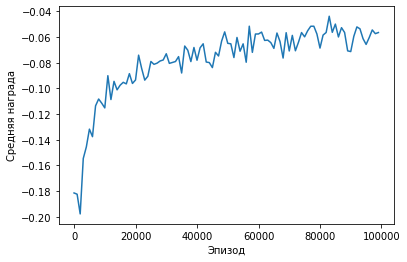

In [148]:
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Средняя награда')
plt.show()

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

#### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде.

In [159]:
from gym.envs.toy_text.blackjack import cmp, is_bust, is_natural, score, sum_hand
from gym import spaces
from gym.envs.toy_text.blackjack import BlackjackEnv


class Doubled_Blackjack_Env(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        self.base_env = gym.make('Blackjack-v1')
        self.action_space = list(range(3))
        super(BlackjackEnv, self).__init__(*args, **kwargs)
        
    def reset(self):
        return self.base_env.reset()
    
    def step(self, action):
        if action == 2:
            state, reward, is_done, _ = self.base_env.step(1)
            if done:
                return state, 2*reward, is_done, _
            else:
                state, reward, is_done, _ = self.base_env.step(0)
                return state, 2*reward, is_done, _
        else:
            return self.base_env.step(action)

class HoffmanBlackjackEnv(Doubled_Blackjack_Env):
    def __init__(self, *args, **kwargs):
        self.base_env = gym.make('Blackjack-v1', natural=True)
        self.na = 3
        self.natural = True
        self.action_space = spaces.Discrete(3)
        self.sum_card = 0
        deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.deck = deck.copy()
        self.card_cost = {
                            1: -1,
                            2: +0.5,
                            3: +1,
                            4: +1,
                            5: +1.5,
                            6: +1,
                            7: +0.5,
                            8: +0,
                            9: -0.5,
                            10: -1,}
        super(HoffmanBlackjackEnv, self).__init__(*args, **kwargs)
        
    def reset(self):
        if len(self.deck) <= 15:
            self.sum_card = 0
            self.deck = deck.copy()
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()

    def draw_card(self):
        card = np.random.choice(self.deck)
        self.deck.remove(card)
        self.sum_card += self.card_cost[card]
        return int(card)
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
        
    def _get_obs(self):
        return (*super(Doubled_Blackjack_V1_Env, self)._get_obs(), self.sum_card)
    
    def step(self, action):
        if action: 
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
                
                
            reward = cmp(score(self.player), score(self.dealer))
            
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
        return self._get_obs(), reward, done, {}

In [160]:
env = HoffmanBlackjackEnv()

In [161]:
Q_mc, evaluations = monte_carlo(episodes=500000)
MC_inference(Q_mc, num_episodes=100000)

-0.051630000000000315

#### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

#### Grid search

In [162]:
%%time
best_sum_of_rewards = -0.19 # наивная стратегия
best_gamma = 0

for gamma in tqdm(np.linspace(0., 1, 100)):
    Q_mc, evaluations = monte_carlo(gamma=1., episodes=500000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    if sum_of_rewards > best_sum_of_rewards:
        best_sum_of_rewards = sum_of_rewards
        best_gamma = gamma

print(f"Лучший выигрыш: {best_sum_of_rewards}, best_gamma: {best_gamma}")

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:18:48<00:00, 47.28s/it]

Лучший выигрыш: -0.04054999999999912, best_gamma: 0.7777777777777778
Wall time: 1h 18min 48s


In [164]:
%%time
sums_of_rewards = []
best_sum_of_rewards = [-0.197] # наивная стратегия

for i in tqdm(range(100)):
    Q_mc, evaluations = monte_carlo(gamma=0.77, episodes=i*1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    sums_of_rewards.append(sum_of_rewards)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:01<00:00,  9.02s/it]

Wall time: 15min 1s


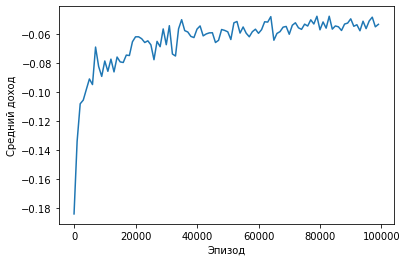

In [165]:
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Средний доход')
plt.show()